In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import ranksums

import os
import glob
import sys
from datetime import date
import json

# from scipy.signal import medfilt
# from scipy.signal import find_peaks

from samb_work import dimtools as dimt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.family':'Arial'})

today = date.today()
today = today.strftime("%Y_%m_%d")

if sys.platform == 'darwin':
    basedir = 'Volumes'
else:
    basedir = 'media'
    
pth = f'/{basedir}/HlabShare/appps1_cortical_communication_samb/figure_3/'

from matplotlib.colors import LinearSegmentedColormap
clist = [(0.1, 0.6, 1.0), (0.05, 0.05, 0.05), (0.8, 0.5, 0.1)]
blue_orange_divergent = LinearSegmentedColormap.from_list("custom_blue_orange", clist)

#--------------------- Colors ---------------------

with open(f'/{basedir}/HlabShare/appps1_cortical_communication_samb/geno_colors.json') as json_file:
    geno_clrs = json.load(json_file)
# --------------------------------------------------

dump = 1

In [2]:
def natural_sort(l):
    #copied from https://stackoverflow.com/questions/4836710/is-there-a-built-in-function-for-string-natural-sort
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

def z_score(binned, baseline_length = 20):
    binbl = np.hstack([binned[:,:baseline_length],binned[:,-baseline_length:]])
    binmean = np.nanmean(binbl,axis=1)
    binstd = np.nanstd(binbl,axis=1)
    binnum = binned - np.reshape(binmean,[np.shape(binmean)[0],1])
    bin_z = binnum/np.reshape(binstd,[np.shape(binstd)[0],1])
    return(bin_z)

def return_sleepdf(sleepfiles):
    '''
    Takes list of sleep numpy files and returns a pd dataframe of start/stop times and sleep states.
    '''
    sleep_states = np.zeros((2,0))

    for idx, f in enumerate(sleepfiles):
        sleeps = np.load(f)
        timestamps = (np.nonzero(np.diff(sleeps))[0]+1)*4
        time_ind = (timestamps/4)-1
        states = sleeps[time_ind.astype(int)]
        timestamps = timestamps+(3600*idx)
        s = np.array(states)
        t = np.stack((timestamps,s))
        sleep_states = np.concatenate((sleep_states,t), axis =1)
        last = idx

    start_time = np.append([0],sleep_states[0,:-1])
    stop_time = sleep_states[0,:]
    sleepstate = sleep_states[1,:]

    sleepdf = pd.DataFrame({'start_time': start_time,'stop_time': stop_time,'sleepstate': sleepstate})
    return(sleepdf)

def bonfcorr(pvals):
    
    from statsmodels.stats.multitest import multipletests as bonferonni

    #bonferroni correction for multiple comparisons
    pvals_bonf = bonferonni(pvals)[1]
    
    return pvals_bonf

def get_signif(pvals):
    pval_labs = np.zeros(len(pvals),dtype='object')

    pval_labs[pvals > 0.05] = ''
    pval_labs[pvals < 0.05] = '*'
    pval_labs[pvals < 0.005] = '**'
    pval_labs[pvals < 0.0001] = '***'

    pval_labs = pval_labs.tolist()
    
    return pval_labs

In [3]:
binsize = 0.001
shiftmax = 80
# epochlen_thresh = 120
# epochlen_thresh = 5*60
epochlen_thresh = 60

wtlist = ['CAF69', 'CAF77', 'CAF81', 'CAF82']
applist = ['CAF71', 'CAF73', 'CAF74', 'CAF75']

allenroidic = {'RSP - VISp': 'rsc_v1', 'RSP - ACAd': 'rsc_acc'}
statenames = {'active': 'wake', 'nrem': 'nrem'}

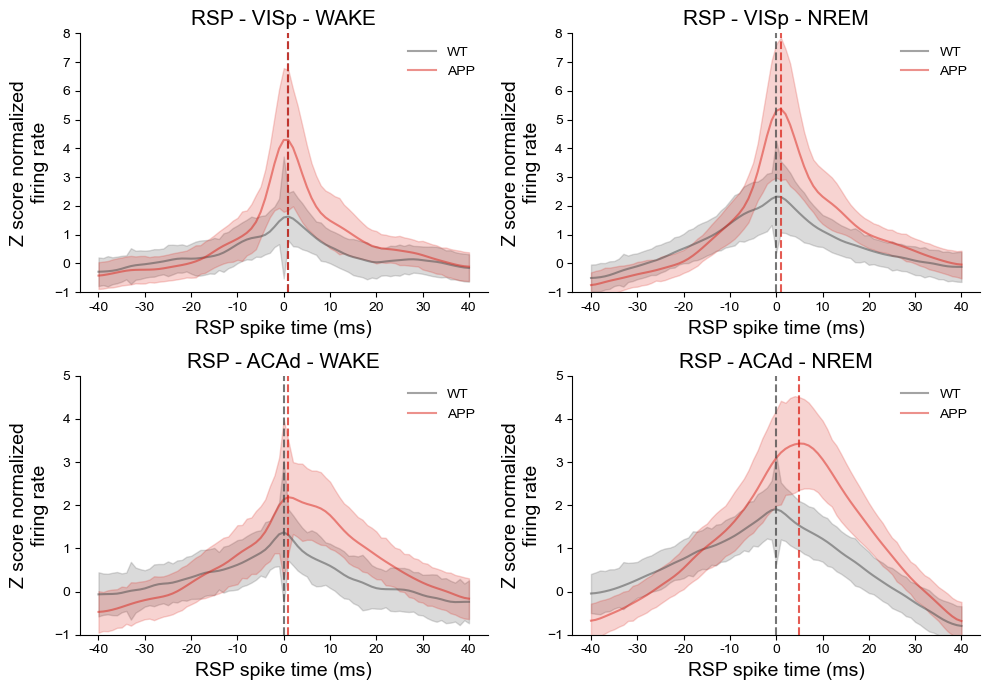

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[10,7])

for ir, inter_rois in enumerate(['RSP - VISp','RSP - ACAd']):

    pwcdata_files = glob.glob(f'/{basedir}/HlabShare/SamB/APPplots/pwc/{allenroidic[inter_rois]}/*mean*.npy')

    sleepstates = ['active','nrem']

    for st, state_of_interest in enumerate(sleepstates):

        pwcdat_wt = np.zeros([1,161])
        pwcdat_app = np.zeros([1,161])

        pwcdata_files_state = [fil for fil in pwcdata_files if (fil.find('_' + state_of_interest) > 0)]

        for fil in pwcdata_files_state:

            animal = fil.split('PWCmean_')[-1].split('_')[0]
            pwcdat_block = np.load(fil)
            fildir = fil.split('PWC')[0]
            filcsv = fil.split('/')[-1].replace('.npy','.csv').replace('mean','epochs')
            stats = pd.read_csv(fildir+filcsv)

            ##do some filtering of epochs
            rowstokeep = np.unique(stats[stats.epoch_len>epochlen_thresh].pwc_row)
            pwcdat_block_filtered = pwcdat_block[rowstokeep,:]

            if animal in wtlist: 
                pwcdat_wt = np.vstack([pwcdat_wt,pwcdat_block_filtered])
            elif animal in applist: 
                pwcdat_app = np.vstack([pwcdat_app,pwcdat_block_filtered])

        #last step to remove first array
        pwcdat_wt = pwcdat_wt[1:,]
        pwcdat_app = pwcdat_app[1:,]
        
        #limit to -40,40 with z scoring in that range
        window = 40
        windind = np.arange(shiftmax -window, ((2*shiftmax) + 1) - (shiftmax-window))
        pwcdat_wt = pwcdat_wt[:,windind]
        pwcdat_app = pwcdat_app[:,windind]
        
        pwcdat_wt_z = z_score(pwcdat_wt)
        pwcdat_app_z = z_score(pwcdat_app)
        
        #remove data with large central peaks
        thresh = 20 #35
        pwcdat_wt_z = pwcdat_wt_z[pwcdat_wt_z[:,40] < thresh,:]
        pwcdat_app_z = pwcdat_app_z[pwcdat_app_z[:,40] < thresh,:]
        
        app_mean = np.nanmean(pwcdat_app_z,axis=0)
        wt_mean = np.nanmean(pwcdat_wt_z,axis=0)
#         app_sem = np.nanstd(pwcdat_app_z,axis=0) / len(applist)
#         wt_sem = np.nanstd(pwcdat_wt_z,axis=0) / len(wtlist)
        app_sem = np.nanstd(pwcdat_app_z,axis=0) / np.sqrt(len(applist))
        wt_sem = np.nanstd(pwcdat_wt_z,axis=0) / np.sqrt(len(wtlist))
        
        wt_mean_smooth = dimt.smooth_spikes(np.reshape(wt_mean,[1,(window*2)+1]),0.001,0.002).ravel()
        app_mean_smooth = dimt.smooth_spikes(np.reshape(app_mean,[1,((window*2)+1)]),0.001,0.002).ravel()
         
        # Plot WT mean and SEM fill:    
        ax[ir,st].plot(wt_mean_smooth,color=geno_clrs['WT'],alpha=0.5,label='WT')
        ax[ir,st].fill_between(np.arange(len(wt_mean_smooth)), wt_mean_smooth-wt_sem, 
                        wt_mean_smooth+wt_sem, color = geno_clrs['WT'],alpha=0.2)

        # Plot APP mean and SEM fill:
        ax[ir,st].plot(app_mean_smooth, color = geno_clrs['APP'], alpha = 0.5, label = 'APP')
        ax[ir,st].fill_between(np.arange(len(app_mean_smooth)), app_mean_smooth-app_sem, 
                        app_mean_smooth+app_sem, color = geno_clrs['APP'],alpha=0.2)

        shiftvals = np.arange(-window,window+1)

        # Plot vertical lines at center of APP and WT corr curves
        ax[ir,st].axvline(np.argmax(wt_mean_smooth), ls = '--', color = geno_clrs['WT'], alpha=0.75)
        ax[ir,st].axvline(np.argmax(app_mean_smooth), ls = '--', color = geno_clrs['APP'], alpha=0.75)

        if ir == 0:
            ax[ir,st].set_ylim(-1,8)
        else:
            ax[ir,st].set_ylim(-1,5) 
                
        xticklabels = np.arange(shiftvals[0],shiftvals[-1]+1,int(len(shiftvals)/8))
        xtickpos = xticklabels + shiftvals[-1]
        
        ax[ir,st].get_xaxis().set_ticks(xtickpos)
        ax[ir,st].get_xaxis().set_ticklabels(xticklabels)
        ax[ir,st].set_xlabel('RSP spike time (ms)',fontsize=14)

        ax[ir,st].set_ylabel('Z score normalized' '\n' 'firing rate',fontsize=14)
        
        ax[ir,st].set_title(f'{inter_rois} - {statenames[state_of_interest].upper()}',fontsize=15)
        ax[ir,st].legend()
        ax[ir,st].legend(frameon=False)
        
        sns.despine()
        
plt.tight_layout()

if dump:
    filename = '_lagged_corr.pdf'
    plt.savefig(pth+today+filename)
else:
    pass

plt.show()

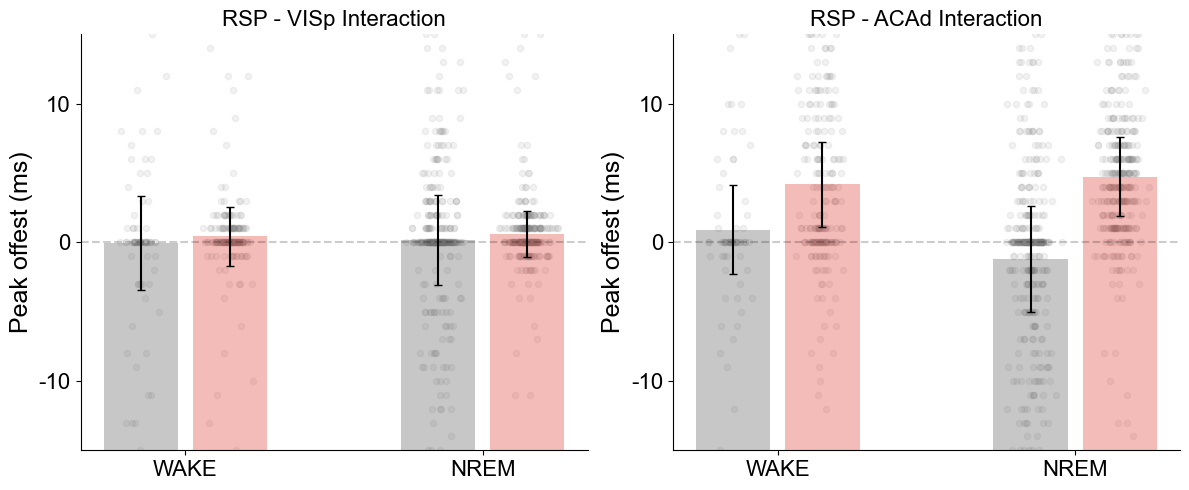

In [9]:
columnnames = ['genotype','peak_pos','state','inter']
peakdf = pd.DataFrame(columns=columnnames)

for r, inter_rois in enumerate(['RSP - VISp','RSP - ACAd']):

    pwcdata_files = glob.glob(f'/{basedir}/HlabShare/SamB/APPplots/pwc/{allenroidic[inter_rois]}/*mean*.npy')

    sleepstates = ['active','nrem']

    for s, state_of_interest in enumerate(sleepstates):
        
        pwcdat_wt = np.zeros([1,161])
        pwcdat_app = np.zeros([1,161])

        pwcdata_files_state = [fil for fil in pwcdata_files if (fil.find(state_of_interest) > 0)]

        for fil in pwcdata_files_state:
            animal = fil.split('PWCmean_')[-1].split('_')[0]
            pwcdat_block = np.load(fil)
            fildir = fil.split('PWC')[0]
            filcsv = fil.split('/')[-1].replace('.npy','.csv').replace('mean','epochs')
            stats = pd.read_csv(fildir+filcsv)

            ##do some filtering of epochs
            rowstokeep = np.unique(stats[stats.epoch_len>epochlen_thresh].pwc_row)
            pwcdat_block_filtered = pwcdat_block[rowstokeep,:]

            if animal in wtlist: 
                pwcdat_wt = np.vstack([pwcdat_wt,pwcdat_block_filtered])
            elif animal in applist:
                pwcdat_app = np.vstack([pwcdat_app,pwcdat_block_filtered])

        #last step to remove first array
        pwcdat_wt = pwcdat_wt[1:,:]
        pwcdat_app = pwcdat_app[1:,:]
        
        z_wt = z_score(pwcdat_wt)
        z_app = z_score(pwcdat_app)
        
        #remove data with large central peaks
        thresh = 20
        z_wt = z_wt[z_wt[:,80] < thresh,:]
        z_app = z_app[z_app[:,80] < thresh,:]

        uniqcond = np.array(['WT','APP'])
        for cond in uniqcond:
            if cond == 'WT':
                z_dat = z_wt
            elif cond == 'APP':
                z_dat = z_app
                       
            flank = np.hstack([z_dat[:,:20],z_dat[:,-20:]])
            center = z_dat[:,60:100]
            thresh = np.mean(flank,axis=1) + (1*np.std(flank,axis=1))
            nopeakind = np.mean(center,axis=1) < thresh
            
            peaks = np.zeros(z_dat.shape[0])
            rowdat_mid = z_dat[:,60:100]
                    
            peaks = (np.argmax(rowdat_mid,axis=1) + 60).astype('float')
            peaks[nopeakind] = np.nan
            
            newdat = np.vstack([np.tile(cond.upper(),len(peaks)),peaks,
                                np.tile(state_of_interest,len(peaks)),
                                np.tile(allenroidic[inter_rois],len(peaks))]).T
            newdf = pd.DataFrame(newdat,columns=columnnames)
            peakdf = peakdf.append(newdf,ignore_index=True)
            peakdf = peakdf.explode('peak_pos')
            peakdf['peak_pos'] = peakdf['peak_pos'].astype('float')
            
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

for r, inter_rois in enumerate(['RSP - VISp','RSP - ACAd']):

    peakdf_roi = peakdf[peakdf.inter==allenroidic[inter_rois]]

    peak_mean = np.zeros(len(sleepstates)*2)
    peak_sem = np.zeros(len(sleepstates)*2)
    count = 0
    # uniqcond = np.unique(peakdf_roi.genotype)
    uniqcond = np.array(['WT','APP'])

    #for every condition and comparison, i.e. bar in the barplot
    for sleepstate in sleepstates:
        for cond in uniqcond:
            bar_cond = cond
            n_animals = 4
            bar_peaks = peakdf_roi[(peakdf_roi.genotype==bar_cond)&(peakdf_roi.state==sleepstate)].peak_pos.values
#             bar_sem = np.nanstd(bar_peaks) / n_animals
            bar_sem = np.nanstd(bar_peaks) / np.sqrt(n_animals)
            peak_mean[count] = np.nanmean(bar_peaks)
            peak_sem[count] = bar_sem
            count += 1

    ###PLOT
    xpos = 0

    for i,comp in enumerate(sleepstates):
        for j,cond in enumerate(uniqcond):
            if j == 0:
                xfudge = 0.2
            elif j == 1:
                xfudge = -0.2

            ax[r].bar(xpos + xfudge,peak_mean[xpos],yerr = peak_sem[xpos],capsize=3,
                        color = geno_clrs[cond.upper()],alpha=0.3, align='center', width=0.5)

            plt_pts = peakdf_roi[(peakdf_roi.genotype==cond)&(peakdf_roi.state==comp)].peak_pos.values
            plt_pts = plt_pts[~np.isnan(plt_pts)]

            jitter = np.random.randn(len(plt_pts)) / 15
            ax[r].scatter(np.tile( xpos + xfudge,len(plt_pts) ) + jitter,
                        plt_pts, s=20, c='grey', alpha=0.1, label = '_nolegend_')

            xpos += 1

    ax[r].set_title(f'{inter_rois} Interaction', fontsize=16)

    shiftvals = np.arange(-shiftmax,shiftmax+1)
    yticklabels = np.arange(shiftvals[0], shiftvals[-1]+1, int(len(shiftvals)/16))
    ytickpos = yticklabels + shiftvals[-1]
    
    ax[r].get_yaxis().set_ticks(ytickpos)
    ax[r].get_yaxis().set_ticklabels(yticklabels,fontsize=16)
    ax[r].set_ylim(65, 95)

    xtickpos = np.arange(0,len(sleepstates)*2,2)
    ax[r].set_ylabel('Peak offest (ms)',fontsize = 18)
    ax[r].set_xlabel('')

    ax[r].get_xaxis().set_ticks(xtickpos+0.5)
    ax[r].get_xaxis().set_ticklabels(['WAKE','NREM'],fontsize=16)

    ax[r].spines['right'].set_visible(False)
    ax[r].spines['top'].set_visible(False)
    
    ax[r].axhline(80, color='black', alpha=0.2, ls='--')


plt.tight_layout()

if dump:
    filename = f'_lagged_corr_peakoffset_bar.pdf'
    plt.savefig(pth+today+filename)
else:
    pass
        
plt.show()

/Users/sbrunwas/anaconda3/envs/spikewords/lib/python3.7/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/Users/sbrunwas/anaconda3/envs/spikewords/lib/python3.7/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


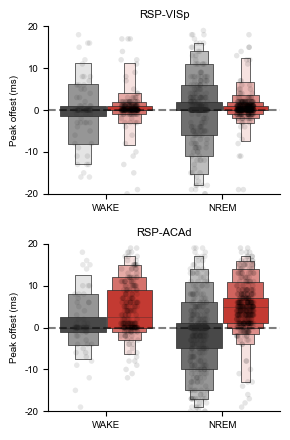

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize = [3, 4.5])

sns.boxenplot(ax = ax[0], data = peakdf[peakdf.inter=='rsc_v1'], x = 'state', y = 'peak_pos', 
            hue='genotype', palette = geno_clrs, showfliers = False, scale = "linear",
             linewidth = 0.5)

sns.boxenplot(ax = ax[1], data = peakdf[peakdf.inter=='rsc_acc'], x = 'state', y = 'peak_pos', 
            hue='genotype', palette = geno_clrs, showfliers = False, scale = "linear",
             linewidth = 0.5)

sns.stripplot(ax = ax[0], data = peakdf[peakdf.inter=='rsc_v1'], x = 'state', hue = 'genotype',  
              dodge = True, y = 'peak_pos', color = 'black', alpha = 0.1, size=4, jitter = 0.15)

sns.stripplot(ax = ax[1], data = peakdf[peakdf.inter=='rsc_acc'], x = 'state', hue = 'genotype', 
              dodge = True, y = 'peak_pos', color = 'black', alpha = 0.1, size=4, jitter = 0.15)

[ax[r].axhline(80, color='black', alpha = 0.5, ls='--') for r in [0,1]]

ax[0].legend([],[], frameon=False)
ax[1].legend([],[], frameon=False)

shiftvals = np.arange(-shiftmax,shiftmax+1)
yticklabels = np.arange(shiftvals[0],shiftvals[-1]+1,int(len(shiftvals)/16))
ytickpos = yticklabels + shiftvals[-1]

ax[0].get_yaxis().set_ticks(ytickpos)
ax[0].get_yaxis().set_ticklabels(yticklabels,fontsize=7)
ax[1].get_yaxis().set_ticks(ytickpos)
ax[1].get_yaxis().set_ticklabels(yticklabels,fontsize=7)

ax[0].set_ylim(60,100)
ax[1].set_ylim(60,100)
ax[0].set_ylabel('Peak offest (ms)', fontsize = 7)
ax[1].set_ylabel('Peak offest (ms)', fontsize = 7)
ax[0].set_title('RSP-VISp', fontsize=8)
ax[1].set_title('RSP-ACAd', fontsize=8)
ax[0].set_xlabel('')
ax[0].get_xaxis().set_ticklabels(['WAKE','NREM'],fontsize=7)
ax[1].set_xlabel('')
ax[1].get_xaxis().set_ticklabels(['WAKE','NREM'],fontsize=7)

sns.despine()

plt.tight_layout()

if dump:
    filename = f'_lagged_corr_peakoffset_boxen.pdf'
    plt.savefig(pth+today+filename)
else:
    pass
        
plt.show()

In [7]:
test = peakdf[peakdf.inter=='rsc_acc']

In [8]:
test2 = test[test.state == 'nrem']
test3 = test2[test2.genotype == 'WT']

In [93]:
np.isnan(test3.peak_pos)

1749    False
1750     True
1751    False
1752    False
1753    False
        ...  
2191    False
2192    False
2193    False
2194    False
2195    False
Name: peak_pos, Length: 447, dtype: bool